7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.95      0.67       103
           1       0.44      0.04      0.08        97

    accuracy                           0.51       200
   macro avg       0.48      0.50      0.37       200
weighted avg       0.48      0.51      0.38       200

Accuracy: 0.51


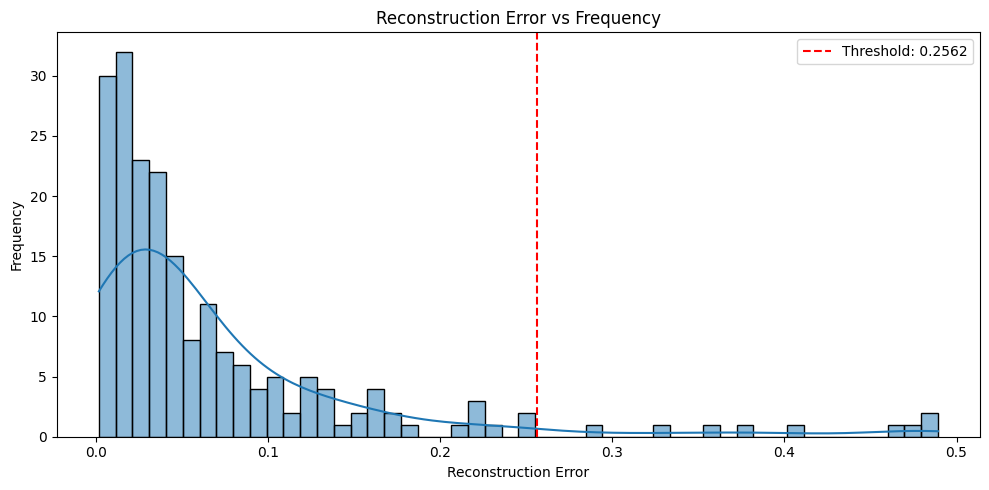

In [13]:
# fraud_detection.ipynb (converted to script for simplicity)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import joblib
import pickle

# Load data
df = pd.read_csv("transactions.csv")

# Drop irrelevant or identifying columns
df = df.drop(columns=["Transaction ID", "Timestamp", "Sender Name", "Receiver Name"])

# Encode UPI IDs
le_sender = LabelEncoder()
le_receiver = LabelEncoder()
df['Sender UPI ID'] = le_sender.fit_transform(df['Sender UPI ID'])
df['Receiver UPI ID'] = le_receiver.fit_transform(df['Receiver UPI ID'])

# Encode Status
# Label: 0 = SUCCESS (normal), 1 = FAILED (anomaly)
df['Status'] = df['Status'].apply(lambda x: 0 if x == 'SUCCESS' else 1)

# Feature scaling
features = ['Sender UPI ID', 'Receiver UPI ID', 'Amount (INR)']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['Status'], test_size=0.2, random_state=42)
X_train_normal = X_train[y_train == 0]  # Autoencoders train only on normal data

# Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=0)

# Save the model
autoencoder.save("autoencoder_model.h5")
with open("autoencoder_model.pkl", "wb") as f:
    pickle.dump(autoencoder, f)

# Predict reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Threshold using training normal data
X_train_pred = autoencoder.predict(X_train_normal)
mse_train = np.mean(np.power(X_train_normal - X_train_pred, 2), axis=1)
threshold = np.percentile(mse_train, 95)

# Classify
y_pred = [1 if e > threshold else 0 for e in mse]

# Evaluation
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot reconstruction error
plt.figure(figsize=(10,5))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Error vs Frequency")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("reconstruction_error.png")
plt.show()
